# Telecom Churn Case Study

## Problem Statement

### Business problem overview
In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business goal.

To reduce customer churn, telecom companies need to predict which customers are at high risk of churn.

In this project, you will analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.

### Understanding and defining churn
There are two main models of payment in the telecom industry - postpaid (customers pay a monthly/annual bill after using the services) and prepaid (customers pay/recharge with a certain amount in advance and then use the services).

In the postpaid model, when customers want to switch to another operator, they usually inform the existing operator to terminate the services, and you directly know that this is an instance of churn.

However, in the prepaid model, customers who want to switch to another network can simply stop using the services without any notice, and it is hard to know whether someone has actually churned or is simply not using the services temporarily (e.g. someone may be on a trip abroad for a month or two and then intend to resume using the services again).

Thus, churn prediction is usually more critical (and non-trivial) for prepaid customers, and the term ‘churn’ should be defined carefully. Also, prepaid is the most common model in India and Southeast Asia, while postpaid is more common in Europe in North America.

This project is based on the Indian and Southeast Asian market.


### Definitions of churn
There are various ways to define churn, such as:

Revenue-based churn: Customers who have not utilised any revenue-generating facilities such as mobile internet, outgoing calls, SMS etc. over a given period of time. One could also use aggregate metrics such as ‘customers who have generated less than INR 4 per month in total/average/median revenue’.

The main shortcoming of this definition is that there are customers who only receive calls/SMSes from their wage-earning counterparts, i.e. they don’t generate revenue but use the services. For example, many users in rural areas only receive calls from their wage-earning siblings in urban areas.

Usage-based churn: Customers who have not done any usage, either incoming or outgoing - in terms of calls, internet etc. over a period of time.

A potential shortcoming of this definition is that when the customer has stopped using the services for a while, it may be too late to take any corrective actions to retain them. For e.g., if you define churn based on a ‘two-months zero usage’ period, predicting churn could be useless since by that time the customer would have already switched to another operator.

In this project, you will use the usage-based definition to define churn.


### High-value churn
In the Indian and the Southeast Asian market, approximately 80% of revenue comes from the top 20% customers (called high-value customers). Thus, if we can reduce churn of the high-value customers, we will be able to reduce significant revenue leakage.

In this project, you will define high-value customers based on a certain metric (mentioned later below) and predict churn only on high-value customers.


### Understanding the business objective and the data
The dataset contains customer-level information for a span of four consecutive months - June, July, August and September. The months are encoded as 6, 7, 8 and 9, respectively.

The business objective is to predict the churn in the last (i.e. the ninth) month using the data (features) from the first three months. To do this task well, understanding the typical customer behaviour during churn will be helpful.


Understanding customer behaviour during churn
Customers usually do not decide to switch to another competitor instantly, but rather over a period of time (this is especially applicable to high-value customers). In churn prediction, we assume that there are three phases of customer lifecycle :

 - The ‘good’ phase: In this phase, the customer is happy with the service and behaves as usual.

- The ‘action’ phase: The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. Also, it is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

- The ‘churn’ phase: In this phase, the customer is said to have churned. You define churn based on this phase. Also, it is important to note that at the time of prediction (i.e. the action months), this data is not available to you for prediction. Thus, after tagging churn as 1/0 based on this phase, you discard all data corresponding to this phase.

In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month is the ‘churn’ phase.

In [135]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [136]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

In [137]:
#Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import scale
from datetime import date,datetime
pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows',1000)

### Step 1: Reading and Understanding data


In [138]:
#Reading data from csv file using pandas
data_df = pd.read_csv("telecom_churn_data.csv")
data_df.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,0.00,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,NaN,4.13,NaN,NaN,NaN,1.15,NaN,NaN,NaN,5.44,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,0.00,0.00,5.44,0.00,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,4,3,

In [139]:
#Understanding data
data_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 226 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    mobile_number             int64  
 1    circle_id                 int64  
 2    loc_og_t2o_mou            float64
 3    std_og_t2o_mou            float64
 4    loc_ic_t2o_mou            float64
 5    last_date_of_month_6      object 
 6    last_date_of_month_7      object 
 7    last_date_of_month_8      object 
 8    last_date_of_month_9      object 
 9    arpu_6                    float64
 10   arpu_7                    float64
 11   arpu_8                    float64
 12   arpu_9                    float64
 13   onnet_mou_6               float64
 14   onnet_mou_7               float64
 15   onnet_mou_8               float64
 16   onnet_mou_9               float64
 17   offnet_mou_6              float64
 18   offnet_mou_7              float64
 19   offnet_mou_8              float64
 20   offn

In [140]:
data_df['mobile_number'].nunique()

99999

mobile_number is the unique id in the dataframe. Lets drop it as it will not be useful in analysis

In [141]:
data_df.drop(['mobile_number'],axis=1,inplace=True)

In [142]:
data_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 225 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    circle_id                 int64  
 1    loc_og_t2o_mou            float64
 2    std_og_t2o_mou            float64
 3    loc_ic_t2o_mou            float64
 4    last_date_of_month_6      object 
 5    last_date_of_month_7      object 
 6    last_date_of_month_8      object 
 7    last_date_of_month_9      object 
 8    arpu_6                    float64
 9    arpu_7                    float64
 10   arpu_8                    float64
 11   arpu_9                    float64
 12   onnet_mou_6               float64
 13   onnet_mou_7               float64
 14   onnet_mou_8               float64
 15   onnet_mou_9               float64
 16   offnet_mou_6              float64
 17   offnet_mou_7              float64
 18   offnet_mou_8              float64
 19   offnet_mou_9              float64
 20   roam

We see from data frame info that columns containing date keyword are of object type whereas rest all columns are numeric in nature. Lets have a variable to store each

In [143]:
all_columns=data_df.columns
date_columns=[x for x in all_columns if 'date' in x]
numeric_columns=[x for x in all_columns if x not in date_columns]

NOTE : the columns with datetime values represented as object, they can be converted into datetime format

In [144]:
# Converting the date columns to datetime format
for i in date_columns:
    data_df[i] = pd.to_datetime(data_df[i])

data_df.shape


(99999, 225)

In [145]:
# Statistical analysis of the numercial features
data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
circle_id,99999.0,109.000000,0.000000,109.000,109.0000,109.000,109.0000,109.000
loc_og_t2o_mou,98981.0,0.000000,0.000000,0.000,0.0000,0.000,0.0000,0.000
std_og_t2o_mou,98981.0,0.000000,0.000000,0.000,0.0000,0.000,0.0000,0.000
loc_ic_t2o_mou,98981.0,0.000000,0.000000,0.000,0.0000,0.000,0.0000,0.000
arpu_6,99999.0,282.987358,328.439770,-2258.709,93.4115,197.704,371.0600,27731.088
arpu_7,99999.0,278.536648,338.156291,-2014.045,86.9805,191.640,365.3445,35145.834
arpu_8,99999.0,279.154731,344.474791,-945.808,84.1260,192.080,369.3705,33543.624
arpu_9,99999.0,261.645069,341.998630,-1899.505,62.6850,176.849,353.4665,38805.617
onnet_mou_6,96062.0,132.395875,297.207406,0.000,7.3800,34.310,118.7400,7376.710
onnet_mou_7,96140.0,133.670805,308.794148,0.000,6.6600,32.330,115.5950,8157.780


In [146]:
# lets check the columns unique values and drop such columns with single value
single_value_attribute=[]
for i in data_df.columns:
    if data_df[i].nunique() == 1:
        single_value_attribute.append(i)
    else:
        pass

data_df.drop(single_value_attribute, axis=1, inplace = True)
print("Following Columns were dropped from the dataset as their unique value is 1. Not useful in deriving any insights\n",
      single_value_attribute)




Following Columns were dropped from the dataset as their unique value is 1. Not useful in deriving any insights
 ['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'last_date_of_month_9', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_og_t2c_mou_9', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8', 'std_ic_t2o_mou_9']


In [147]:
#checking data set shape
data_df.shape

(99999, 209)

###  Step 2: Treating and handling missing values in df

In [148]:
#checking %age of missing across each columns
round((data_df.isnull().sum()/data_df.shape[0])*100,2).sort_values(ascending=False)

arpu_3g_6                   74.85
night_pck_user_6            74.85
count_rech_3g_6             74.85
max_rech_data_6             74.85
av_rech_amt_data_6          74.85
total_rech_data_6           74.85
date_of_last_rech_data_6    74.85
count_rech_2g_6             74.85
fb_user_6                   74.85
arpu_2g_6                   74.85
night_pck_user_7            74.43
fb_user_7                   74.43
count_rech_2g_7             74.43
arpu_2g_7                   74.43
av_rech_amt_data_7          74.43
total_rech_data_7           74.43
arpu_3g_7                   74.43
max_rech_data_7             74.43
count_rech_3g_7             74.43
date_of_last_rech_data_7    74.43
night_pck_user_9            74.08
total_rech_data_9           74.08
fb_user_9                   74.08
max_rech_data_9             74.08
date_of_last_rech_data_9    74.08
arpu_2g_9                   74.08
av_rech_amt_data_9          74.08
count_rech_2g_9             74.08
arpu_3g_9                   74.08
count_rech_3g_

In [149]:
data_df.head()

,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,0.00,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,NaN,4.13,NaN,NaN,NaN,1.15,NaN,NaN,NaN,5.44,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,0.00,0.00,5.44,0.00,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,4,3,2,6,362,252,252,0,252,252,252,0,2014-06-21,2014-07-16,2014-08-08,2014-09-28,252,252,252,0,2014-06-21,2014-07-16,2014-08-08,NaT,1.0,1.0,1.0,NaN,252.0,252.0,252.0,NaN,0.0,0.0,0.0,NaN,1.0,1.0,1.0,NaN,252.0,252.0,252.0,NaN,30.13,1.32,5.75,0.0,83.57,150.76,109.61,0.00,212.17,212.17,212.17,NaN,212.17,212.17,212.17,NaN,0.0,0.0,0.0,NaN,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1.0,1.0,1.0,NaN,968,30.4,0

#### Treating missing values of numeric column
1. We can consider columns total_rech_data_*, max_rech_data_*, av_rech_amt_data_* and for month 6,7,8 and 9 missing value to be 0. Customer has not done any recharge for mobile internet. In short we can impute missing value for all numeric column with 0
2. Drop non-numeric columns with high %age missing value (> 70%)
3. Impute missing value of date_of_last_rech_* for the month of 6,7,8,9 with mode value

In [150]:
numeric_columns = [x for x in numeric_columns if x not in single_value_attribute]
data_df[numeric_columns]=data_df[numeric_columns].fillna(0)

In [151]:
#checking again the %age of missing values
round((data_df.isnull().sum()/data_df.shape[0])*100,2).sort_values(ascending=False)

date_of_last_rech_data_6    74.85
date_of_last_rech_data_7    74.43
date_of_last_rech_data_9    74.08
date_of_last_rech_data_8    73.66
date_of_last_rech_9          4.76
date_of_last_rech_8          3.62
date_of_last_rech_7          1.77
date_of_last_rech_6          1.61
total_ic_mou_7               0.00
last_day_rch_amt_6           0.00
last_day_rch_amt_7           0.00
last_day_rch_amt_8           0.00
last_day_rch_amt_9           0.00
arpu_6                       0.00
total_rech_data_7            0.00
total_rech_data_8            0.00
total_rech_data_9            0.00
max_rech_data_6              0.00
max_rech_data_7              0.00
max_rech_data_8              0.00
max_rech_data_9              0.00
count_rech_2g_6              0.00
count_rech_2g_7              0.00
count_rech_2g_8              0.00
count_rech_2g_9              0.00
total_rech_data_6            0.00
max_rech_amt_9               0.00
max_rech_amt_8               0.00
ic_others_7                  0.00
total_ic_mou_9

In [152]:
#dropping columns with high %age missing value > 70%
col_to_drop = ['date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8','date_of_last_rech_data_9']
data_df = data_df.drop(col_to_drop,axis=1)
data_df.shape

(99999, 205)

In [153]:
#checking again the %age of missing values
round((data_df.isnull().sum()/data_df.shape[0])*100,2).sort_values(ascending=False)

date_of_last_rech_9    4.76
date_of_last_rech_8    3.62
date_of_last_rech_7    1.77
date_of_last_rech_6    1.61
arpu_6                 0.00
total_rech_data_7      0.00
max_rech_amt_9         0.00
last_day_rch_amt_6     0.00
last_day_rch_amt_7     0.00
last_day_rch_amt_8     0.00
last_day_rch_amt_9     0.00
total_rech_data_6      0.00
total_rech_data_8      0.00
max_rech_amt_7         0.00
total_rech_data_9      0.00
max_rech_data_6        0.00
max_rech_data_7        0.00
max_rech_data_8        0.00
max_rech_data_9        0.00
count_rech_2g_6        0.00
count_rech_2g_7        0.00
count_rech_2g_8        0.00
count_rech_2g_9        0.00
count_rech_3g_6        0.00
max_rech_amt_8         0.00
max_rech_amt_6         0.00
std_ic_mou_9           0.00
isd_ic_mou_9           0.00
total_ic_mou_7         0.00
total_ic_mou_8         0.00
total_ic_mou_9         0.00
spl_ic_mou_6           0.00
spl_ic_mou_7           0.00
spl_ic_mou_8           0.00
spl_ic_mou_9           0.00
isd_ic_mou_6        

In [154]:
#lets impute missing value of date_of_last_rech_* for the month of 6,7,8,9 with mode value
date_col_with_missing_values = ['date_of_last_rech_9','date_of_last_rech_8','date_of_last_rech_7','date_of_last_rech_6']

data_df.loc[data_df['date_of_last_rech_9'].isnull(),['date_of_last_rech_9']] = data_df['date_of_last_rech_9'].mode()[0]
data_df.loc[data_df['date_of_last_rech_8'].isnull(),['date_of_last_rech_8']] = data_df['date_of_last_rech_8'].mode()[0]
data_df.loc[data_df['date_of_last_rech_7'].isnull(),['date_of_last_rech_7']] = data_df['date_of_last_rech_7'].mode()[0]
data_df.loc[data_df['date_of_last_rech_6'].isnull(),['date_of_last_rech_6']] = data_df['date_of_last_rech_6'].mode()[0]
data_df.head()

# data_df[date_col_with_missing_values] = data_df[date_col_with_missing_values].fillna(datetime.strptime('1970-01-01', '%Y-%m-%d')) 
# data_df[data_df['date_of_last_rech_9'] == '1970-01-01']


,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,197.385,214.816,213.803,21.100,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.16,0.00,0.00,0.00,4.13,0.00,0.00,0.00,1.15,0.00,0.00,0.00,5.44,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.44,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.00,4,3,2,6,362,252,252,0,252,252,252,0,2014-06-21,2014-07-16,2014-08-08,2014-09-28,252,252,252,0,1.0,1.0,1.0,0.0,252.0,252.0,252.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,252.0,252.0,252.0,0.0,30.13,1.32,5.75,0.0,83.57,150.76,109.61,0.00,212.17,212.17,212.17,0.00,212.17,212.17,212.17,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1.0,1.0,1.0,0.0,968,30.4,0.0,101.20,3.58
1,34.047,355.074,268.321,86.285,24.11,78.68,7.68,1

In [156]:
#checking again the %age of missing values
round((data_df.isnull().sum()/data_df.shape[0])*100,2).sort_values(ascending=False)

arpu_6                 0.0
total_rech_data_7      0.0
max_rech_amt_9         0.0
date_of_last_rech_6    0.0
date_of_last_rech_7    0.0
date_of_last_rech_8    0.0
date_of_last_rech_9    0.0
last_day_rch_amt_6     0.0
last_day_rch_amt_7     0.0
last_day_rch_amt_8     0.0
last_day_rch_amt_9     0.0
total_rech_data_6      0.0
total_rech_data_8      0.0
max_rech_amt_7         0.0
total_rech_data_9      0.0
max_rech_data_6        0.0
max_rech_data_7        0.0
max_rech_data_8        0.0
max_rech_data_9        0.0
count_rech_2g_6        0.0
count_rech_2g_7        0.0
count_rech_2g_8        0.0
count_rech_2g_9        0.0
count_rech_3g_6        0.0
max_rech_amt_8         0.0
max_rech_amt_6         0.0
std_ic_mou_9           0.0
isd_ic_mou_9           0.0
total_ic_mou_7         0.0
total_ic_mou_8         0.0
total_ic_mou_9         0.0
spl_ic_mou_6           0.0
spl_ic_mou_7           0.0
spl_ic_mou_8           0.0
spl_ic_mou_9           0.0
isd_ic_mou_6           0.0
isd_ic_mou_7           0.0
i

NOTE: There are no missing values in the data. Let move to next step of data preparation

### Step 3: Data Preparation

#### Derive new features

This is one of the most important parts of data preparation since good features are often the differentiators between good and bad models.

In [157]:
# Code for deriving new features
data_df['total_service_packs_6'] = data_df['night_pck_user_6']+data_df['monthly_2g_6']+data_df['sachet_2g_6']+data_df['monthly_3g_6']+data_df['sachet_3g_6']+data_df['fb_user_6']
data_df['total_service_packs_7'] = data_df['night_pck_user_7']+data_df['monthly_2g_7']+data_df['sachet_2g_7']+data_df['monthly_3g_7']+data_df['sachet_3g_7']+data_df['fb_user_7']
data_df['total_service_packs_8'] = data_df['night_pck_user_8']+data_df['monthly_2g_8']+data_df['sachet_2g_8']+data_df['monthly_3g_8']+data_df['sachet_3g_8']+data_df['fb_user_8']
data_df['total_service_packs_9'] = data_df['night_pck_user_9']+data_df['monthly_2g_9']+data_df['sachet_2g_9']+data_df['monthly_3g_9']+data_df['sachet_3g_9']+data_df['fb_user_9']
data_df['diff_ic_og_6'] = data_df['total_ic_mou_6']-data_df['total_og_mou_6']
data_df['diff_ic_og_7'] = data_df['total_ic_mou_7']-data_df['total_og_mou_7']
data_df['diff_ic_og_8'] = data_df['total_ic_mou_8']-data_df['total_og_mou_8']
data_df['diff_ic_og_9'] = data_df['total_ic_mou_9']-data_df['total_og_mou_9']
data_df['diff_vol_3g_2g_6'] = data_df['vol_3g_mb_6']-data_df['vol_2g_mb_6']
data_df['diff_vol_3g_2g_7'] = data_df['vol_3g_mb_7']-data_df['vol_2g_mb_7']
data_df['diff_vol_3g_2g_8'] = data_df['vol_3g_mb_8']-data_df['vol_2g_mb_8']
data_df['diff_vol_3g_2g_9'] = data_df['vol_3g_mb_9']-data_df['vol_2g_mb_9']
data_df['diff_total_service_packs_good_active_phase']=data_df['total_service_packs_6']+data_df['total_service_packs_7']-data_df['total_service_packs_8']
data_df['diff_ic_good_active_phase']=data_df['total_ic_mou_6']+data_df['total_ic_mou_7']-data_df['total_ic_mou_8']
data_df['diff_og_good_active_phase']=data_df['total_og_mou_6']+data_df['total_og_mou_7']-data_df['total_og_mou_8']
data_df['diff_2g_good_active_phase']=data_df['vol_2g_mb_6']+data_df['vol_2g_mb_7']-data_df['vol_2g_mb_8']
data_df['diff_3g_good_active_phase']=data_df['vol_3g_mb_6']+data_df['vol_3g_mb_7']-data_df['vol_3g_mb_8']
data_df['diff_total_rech_amt_good_active']= data_df['total_rech_amt_6']+data_df['total_rech_amt_7']-data_df['total_rech_amt_8']
tn_range = [0, 6, 12, 24, 60, 61]
tn_label = [ '0-6 Months', '6-12 Months', '1-2 Yrs', '2-5 Yrs', '5 Yrs and above']
data_df['tenure_range'] = pd.cut((data_df['aon']/30).round(0), tn_range, labels=tn_label)
data_df[['tenure_range']] = data_df[['tenure_range']].fillna('5 Yrs and above')
data_df[['aon','tenure_range']].head(20)

,aon,tenure_range
0,968,2-5 Yrs
1,1006,2-5 Yrs
2,1103,2-5 Yrs
3,2491,5 Yrs and above
4,1526,2-5 Yrs
5,1471,2-5 Yrs
6,1673,2-5 Yrs
7,802,2-5 Yrs
8,315,6-12 Months
9,902,2-5 Yrs


In [158]:
#checking again the %age of missing values
round((data_df.isnull().sum()/data_df.shape[0])*100,2).sort_values(ascending=False)


arpu_6                                        0.0
arpu_7                                        0.0
total_rech_data_8                             0.0
total_rech_data_9                             0.0
max_rech_data_6                               0.0
max_rech_data_7                               0.0
max_rech_data_8                               0.0
max_rech_data_9                               0.0
count_rech_2g_6                               0.0
count_rech_2g_7                               0.0
count_rech_2g_8                               0.0
count_rech_2g_9                               0.0
count_rech_3g_6                               0.0
count_rech_3g_7                               0.0
count_rech_3g_8                               0.0
count_rech_3g_9                               0.0
av_rech_amt_data_6                            0.0
av_rech_amt_data_7                            0.0
av_rech_amt_data_8                            0.0
av_rech_amt_data_9                            0.0


#### Filter high-value customers

We need to predict churn only for the high-value customers. 

Defining high-value customers as follows: Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).

In [159]:
#Filtering the high value cuustomers
data_df['total_rech_data_amt_good_phase'] = data_df['total_rech_data_6']*data_df['av_rech_amt_data_6']+ data_df['total_rech_data_7']*data_df['av_rech_amt_data_7']
data_df['total_rech_amt_good_phase'] = data_df['total_rech_amt_6']+data_df['total_rech_amt_7']
data_df['total_amt_good_phase'] = data_df['total_rech_data_amt_good_phase']+data_df['total_rech_amt_good_phase']
data_df['total_amt_good_phase'].describe(percentiles=[.25,.5,.70,.90,.95,.99])


count     99999.000000
mean        970.656135
std        1738.847187
min           0.000000
25%         256.000000
50%         550.000000
70%         956.000000
90%        2056.000000
95%        3024.000000
99%        6727.020000
max      122472.000000
Name: total_amt_good_phase, dtype: float64

In [163]:
#checking again the 70th percentile
data_df['total_amt_good_phase'].quantile(0.70)

956.0

In [164]:
data_df_hvc=data_df[data_df['total_amt_good_phase']>=data_df['total_amt_good_phase'].quantile(0.70)]

In [165]:
data_df_hvc.shape

(30001, 227)

#### Tag churners and remove attributes of the churn phase

Now tag the churned customers (churn=1, else 0) based on the fourth month as follows: Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase. The attributes you need to use to tag churners are:

1. total_ic_mou_9
2. total_og_mou_9
3. vol_2g_mb_9
4. vol_3g_mb_9

In [166]:
data_df_hvc['churn']=data_df_hvc['total_ic_mou_9']+data_df_hvc['total_og_mou_9']+data_df_hvc['vol_2g_mb_9']+data_df_hvc['vol_3g_mb_9']
data_df_hvc['churn']=data_df_hvc['churn'].apply(lambda x: 1 if x==0 else 0)

In [167]:
data_df_hvc.churn.value_counts()

0    27560
1     2441
Name: churn, dtype: int64

In [168]:
data_df_hvc.shape

(30001, 228)

In [169]:
#Removing churn phase attributes (column containing '_9' in their name)
churn_phase_columns = [x for x in data_df_hvc.columns if '_9' in x]
churn_phase_columns

['arpu_9',
 'onnet_mou_9',
 'offnet_mou_9',
 'roam_ic_mou_9',
 'roam_og_mou_9',
 'loc_og_t2t_mou_9',
 'loc_og_t2m_mou_9',
 'loc_og_t2f_mou_9',
 'loc_og_t2c_mou_9',
 'loc_og_mou_9',
 'std_og_t2t_mou_9',
 'std_og_t2m_mou_9',
 'std_og_t2f_mou_9',
 'std_og_mou_9',
 'isd_og_mou_9',
 'spl_og_mou_9',
 'og_others_9',
 'total_og_mou_9',
 'loc_ic_t2t_mou_9',
 'loc_ic_t2m_mou_9',
 'loc_ic_t2f_mou_9',
 'loc_ic_mou_9',
 'std_ic_t2t_mou_9',
 'std_ic_t2m_mou_9',
 'std_ic_t2f_mou_9',
 'std_ic_mou_9',
 'total_ic_mou_9',
 'spl_ic_mou_9',
 'isd_ic_mou_9',
 'ic_others_9',
 'total_rech_num_9',
 'total_rech_amt_9',
 'max_rech_amt_9',
 'date_of_last_rech_9',
 'last_day_rch_amt_9',
 'total_rech_data_9',
 'max_rech_data_9',
 'count_rech_2g_9',
 'count_rech_3g_9',
 'av_rech_amt_data_9',
 'vol_2g_mb_9',
 'vol_3g_mb_9',
 'arpu_3g_9',
 'arpu_2g_9',
 'night_pck_user_9',
 'monthly_2g_9',
 'sachet_2g_9',
 'monthly_3g_9',
 'sachet_3g_9',
 'fb_user_9',
 'total_service_packs_9',
 'diff_ic_og_9',
 'diff_vol_3g_2g_9']

In [170]:
#dropping all churn phase columns
data_df_hvc = data_df_hvc.drop(churn_phase_columns,axis=1)
data_df_hvc.shape

(30001, 175)

In [171]:
data_df_hvc.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30001 entries, 0 to 99997
Data columns (total 175 columns):
 #    Column                                      Dtype         
---   ------                                      -----         
 0    arpu_6                                      float64       
 1    arpu_7                                      float64       
 2    arpu_8                                      float64       
 3    onnet_mou_6                                 float64       
 4    onnet_mou_7                                 float64       
 5    onnet_mou_8                                 float64       
 6    offnet_mou_6                                float64       
 7    offnet_mou_7                                float64       
 8    offnet_mou_8                                float64       
 9    roam_ic_mou_6                               float64       
 10   roam_ic_mou_7                               float64       
 11   roam_ic_mou_8                          

#### Checking for outliers in numeric columns

In [172]:
numeric_columns = data_df_hvc.select_dtypes(exclude=['category','datetime64']).columns
numeric_columns

Index(['arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7',
       'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8',
       'roam_ic_mou_6',
       ...
       'diff_total_service_packs_good_active_phase',
       'diff_ic_good_active_phase', 'diff_og_good_active_phase',
       'diff_2g_good_active_phase', 'diff_3g_good_active_phase',
       'diff_total_rech_amt_good_active', 'total_rech_data_amt_good_phase',
       'total_rech_amt_good_phase', 'total_amt_good_phase', 'churn'],
      dtype='object', length=171)

In [175]:
temp_df = data_df_hvc[numeric_columns]
temp_df.describe(percentiles=[0.02,.25,.5,.75,.90,.95,.99]).T

,count,mean,std,min,2%,25%,50%,75%,90%,95%,99%,max
arpu_6,30001.0,558.490824,460.640461,-2258.709,39.839,309.865,481.694,699.943,994.099,1240.964,1985.115,27731.088
arpu_7,30001.0,560.782203,479.776947,-2014.045,43.957,309.826,480.943,698.315,995.859,1261.272,1999.500,35145.834
arpu_8,30001.0,508.597957,501.961981,-945.808,0.000,231.473,427.585,661.491,977.345,1255.019,1986.622,33543.624
onnet_mou_6,30001.0,260.793024,459.644368,0.000,0.000,17.080,84.580,290.440,754.160,1135.440,2151.740,7376.710
onnet_mou_7,30001.0,267.819295,479.993989,0.000,0.000,16.030,82.810,290.240,784.480,1185.790,2201.960,8157.780
onnet_mou_8,30001.0,234.112539,458.448598,0.000,0.000,10.390,65.610,239.960,665.080,1074.590,2159.110,10752.560
offnet_mou_6,30001.0,373.693961,482.523558,0.000,0.000,71.610,222.540,487.940,895.830,1256.610,2326.360,8362.360
offnet_mou_7,30001.0,378.103169,498.923555,0.000,0.000,69.910,220.030,494.010,916.080,1272.290,2410.890,9667.130
offnet_mou_8,30001.0,335.077044,482.062509,0.000,0.000,46.740,182.790,438.890,823.680,1167.540,2193.130,14007.340
roam_ic_mou_6,30001.0,16.110355,76.302156,0.000,0.000,0.000,0.000,0.000,27.390,84.540,342.440,2613.310


There are outliers in our data. Lets treat them now.

In [184]:
iqr = 1.5*(temp_df['total_amt_good_phase'].quantile(0.75) - temp_df['total_amt_good_phase'].quantile(0.25))
print("IQR = ", iqr)
print("lower = ",temp_df['total_amt_good_phase'].quantile(0.01))
print("upper = ",temp_df['total_amt_good_phase'].quantile(0.99))

IQR =  1815.0
lower =  965.0
upper =  12181.0


In [189]:
#creating a copy of data as final_dataframe
final_non_outlier_df = data_df_hvc.copy()


#### Outliers treatment

##### NOTE:
capping outliers to 1st percentile and 99th percentile for lower and upper outlier values

In [190]:
def cap_outliers_with_iqr(arr):
    lower = arr.quantile(0.01)
    upper = arr.quantile(0.99)
    arr[arr<lower] = lower
    arr[arr>upper] = upper
    return arr

final_non_outlier_df[numeric_columns] = final_non_outlier_df[numeric_columns].apply(cap_outliers_with_iqr)

In [34]:
# lower_cut_off = 0.001
# upper_cut_off = 0.999
# non_outlier_ranges = temp_df.quantile([lower_cut_off,upper_cut_off])
# non_outlier_ranges

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_service_packs_6,total_service_packs_7,total_service_packs_8,diff_ic_og_6,diff_ic_og_7,diff_ic_og_8,diff_vol_3g_2g_6,diff_vol_3g_2g_7,diff_vol_3g_2g_8,diff_total_service_packs_good_active_phase,diff_ic_good_active_phase,diff_og_good_active_phase,diff_2g_good_active_phase,diff_3g_good_active_phase,diff_total_rech_amt_good_active,total_rech_data_amt_good_phase,total_rech_amt_good_phase,total_amt_good_phase,churn
0.001,7.000002e+09,-3.000,-7.420,-5.000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.00,-7.28,-0.58,-1.36,-3.82,-0.29,-0.98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,181.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,-5118.32,-5532.32,-5556.18,-3210.72,-3430.73,-3241.01,-11.0,-930.21,-2169.95,-1705.55,-3827.87,-1302.0,0.0,86.0,956.0,0.0
0.999,7.002408e+09,3884.712,4115.703,3976.261,4136.34,4355.98,4165.71,4175.83,4546.48,4472.46,920.59,1022.38,917.96,1458.89,1244.64,1365.11,3006.24,3098.94,2767.29,2401.48,2192.58,2099.48,257.18,242.26,234.68,72.29,90.53,75.43,3508.19,3604.84,3353.39,3708.53,3877.74,3779.73,3884.23,4267.94,4240.41,180.08,183.98,161.74,4929.71,5003.64,5269.71,301.69,302.21,358.88,208.46,253.73,273.46,23.53,6.09,6.7,5423.59,5766.44,5762.48,2182.88,2436.23,2169.71,2225.44,2356.78,2172.51,512.79,602.33,487.44,3075.4

In [35]:
# non_outlier_df = temp_df.apply(lambda x: x[(x>=non_outlier_ranges.loc[lower_cut_off,x.name]) & (x <= non_outlier_ranges.loc[upper_cut_off,x.name])], axis=0)
# non_outlier_df.shape


(30001, 172)

In [36]:
# #Merging with the final dataframe
# final_non_outlier_df = pd.concat([final_df.loc[:, ~final_df.columns.isin([x for x in final_df.columns if x in numeric_columns])], non_outlier_df], axis=1)
# final_non_outlier_df


,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,tenure_range,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_service_packs_6,total_service_packs_7,total_service_packs_8,diff_ic_og_6,diff_ic_og_7,diff_ic_og_8,diff_vol_3g_2g_6,diff_vol_3g_2g_7,diff_vol_3g_2g_8,diff_total_service_packs_good_active_phase,diff_ic_good_active_phase,diff_og_good_active_phase,diff_2g_good_active_phase,diff_3g_good_active_phase,diff_total_rech_amt_good_active,total_rech_data_amt_good_phase,total_rech_amt_good_phase,total_amt_good_phase,churn
0,2014-06-21,2014-07-16,2014-08-08,2-5 Yrs,7.000843e+09,197.385,214.816,213.803,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.16,0.00,0.00,4.13,0.00,0.00,1.15,0.00,0.00,5.44,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.44,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,4.0,3.0,2.0,362.0,252.0,252.0,252.0,252.0,252.0,252.0,252.0,252.0,1.0,1.0,1.0,252.0,252.0,252.0,0.0,0.0,0.0,1.0,1.0,1.0,252.0,252.0,252.0,30.13,1.32,5.75,83.57,150.76,109.61,212.17,212.17,212.17,212.17,212.17,212.17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,968.0,30.40,0.00,101.20,3.58,2.0,2.0,2.0,0.00,0.00,5.44,53.44,149.44,103.86,2.0,-5.44,0.00,25.70,124.72,362.0,504.0,614.0,1118.0,1
7,2014-06-27,2014-07-25,2014-08-26,2-5 Yrs,7.000702e+09,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.00,0.00,0.00,422.16,533.91,255.79,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,60.86,75.14,77.84,0.0,0.18,10.01,4.50,0.00,6.50,0.00,0.0,0.0,487.53,609.24

In [191]:
final_non_outlier_df.shape

(30001, 175)

In [192]:
#dropping na values
final_non_outlier_df.dropna(inplace=True)
final_non_outlier_df.shape

(30001, 175)

### Checking correlation

In [193]:
#Correlation matrix 
final_non_outlier_df.corr()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_service_packs_6,total_service_packs_7,total_service_packs_8,diff_ic_og_6,diff_ic_og_7,diff_ic_og_8,diff_vol_3g_2g_6,diff_vol_3g_2g_7,diff_vol_3g_2g_8,diff_total_service_packs_good_active_phase,diff_ic_good_active_phase,diff_og_good_active_phase,diff_2g_good_active_phase,diff_3g_good_active_phase,diff_total_rech_amt_good_active,total_rech_data_amt_good_phase,total_rech_amt_good_phase,total_amt_good_phase,churn
arpu_6,1.000000,0.595966,0.506669,0.426980,0.273604,0.237711,0.600623,0.394485,0.347943,0.154759,0.123657,0.132396,0.208736,0.158281,0.161176,0.260813,0.208502,0.195790,0.421733,0.320589,0.288708,0.200443,0.163189,0.153181,0.073495,0.004742,0.015119,0.431289,0.334388,0.299125,0.329024,0.194543,0.164587,0.370609,0.225923,0.189480,0.098947,0.077610,0.071265,0.472115,0.282290,0.232244,0.216611,0.135600,0.142203,0.147117,0.062607,0.060611,0.155047,NaN,NaN,0.665922,0.433313,0.364593,0.177585,0.137739,0.126979,0.263270,0.206408,0.175944,0.089532,0.073383,0.065005,0.260081,0.201872,0.174675,0.186849,0.126966,0.112019,0.185130,0.124294,0.114733,0.069932,0.052826,0.046506,0.210558,0.143182,0.128482,0.300707,0.224437,0.196336,0.055330,-0.097113,-0.018617,0.111836,0.072374,0.067781,0.073014,0.048793,0.046873,0.415430,0.155478,0.132178,0.938769,0.568259,0.491192,0.337304,0.224775,0.255371,0.268782,0.173486,0.191740,-0.155184,-0.243913,-0.174668,0.055125,-0.051490,0.005533,-0.215406,-0.274238,-0.212235,0.105859,-0.000607,0.039083,0.063773,-0.085393,-0.008200,-0.095570,-0.145958,-0.115344,0.133609,0.043408,0.060161,0.235889,0.103991,0.135347,0.206439,0.079376,0.114578,0.012441,-0.005505,0.008362,-0.044651,-0.100762,-0.072346,-0.207201,-0.255164,-0.200036,0.180304,0.072470,0.106939,-0.031453,-0.068474,-0.051900,-0.147440,-0.239962,-0.171715,0.057704,0.047694,0.047927,0.110846,0.045242,

In [194]:
# lets check the correlation amongst the independent variables, drop the highly correlated ones
final_non_outlier_df_corr = final_non_outlier_df.corr()
final_non_outlier_df_corr.loc[:,:] = np.tril(final_non_outlier_df_corr, k=-1)
final_non_outlier_df_corr = final_non_outlier_df_corr.stack()
final_non_outlier_df_corr
final_non_outlier_df_corr[(final_non_outlier_df_corr > 0.80) | (final_non_outlier_df_corr < -0.80)].sort_values(ascending=False)



total_service_packs_7                       total_rech_data_7                  0.989827
total_service_packs_6                       total_rech_data_6                  0.988510
total_service_packs_8                       total_rech_data_8                  0.988485
sachet_2g_8                                 count_rech_2g_8                    0.984508
sachet_2g_7                                 count_rech_2g_7                    0.983685
sachet_2g_6                                 count_rech_2g_6                    0.982320
arpu_2g_8                                   arpu_3g_8                          0.945653
total_rech_amt_8                            arpu_8                             0.945223
diff_vol_3g_2g_8                            vol_3g_mb_8                        0.943723
arpu_2g_7                                   arpu_3g_7                          0.943391
arpu_2g_6                                   arpu_3g_6                          0.940723
total_rech_amt_6                

In [195]:
col_to_drop=['total_rech_amt_8','isd_og_mou_8','isd_og_mou_7','sachet_2g_8','total_ic_mou_6',
            'total_ic_mou_8','total_ic_mou_7','std_og_t2t_mou_6','std_og_t2t_mou_8','std_og_t2t_mou_7',
            'std_og_t2m_mou_7','std_og_t2m_mou_8',]

# These columns can be dropped as they are highly collinered with other predictor variables.
# criteria set is for collinearity of 85%

#  dropping these column
final_non_outlier_df.drop(col_to_drop, axis=1, inplace=True)

In [196]:

final_non_outlier_df['churn'].value_counts()

0    27560
1     2441
Name: churn, dtype: int64

Text(0.5, 1.0, 'churned')

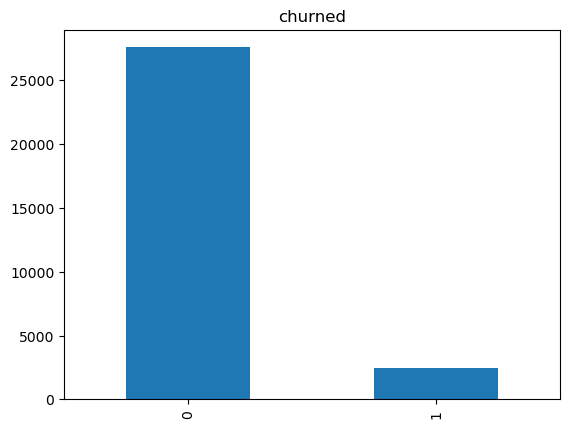

In [197]:
final_non_outlier_df['churn'].value_counts().plot(kind='bar').set_title('churned')

### Handling class imbalance using SMOTE

In [198]:
#Converting datetime to categories
final_non_outlier_df['date_of_last_rech_6'] = final_non_outlier_df['date_of_last_rech_6'].astype('category')
final_non_outlier_df['date_of_last_rech_7'] = final_non_outlier_df['date_of_last_rech_7'].astype('category')
final_non_outlier_df['date_of_last_rech_8'] = final_non_outlier_df['date_of_last_rech_8'].astype('category')
cat_columns = final_non_outlier_df.select_dtypes(['category']).columns
final_non_outlier_df[cat_columns] = final_non_outlier_df[cat_columns].apply(lambda x: x.cat.codes)


In [45]:
# !pip install imblearn

In [46]:
# !pip install delayed

In [199]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
# Separate input features and target
y = final_non_outlier_df.churn
X = final_non_outlier_df.drop('churn', axis=1)
# scaling the features
X_scaled = scale(X)
# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=0.7, test_size=0.3, random_state=100)

sm = SMOTE(random_state=42)
X_train_sm,y_train_sm = sm.fit_resample(X_train,y_train)

Text(0.5, 1.0, 'churned')

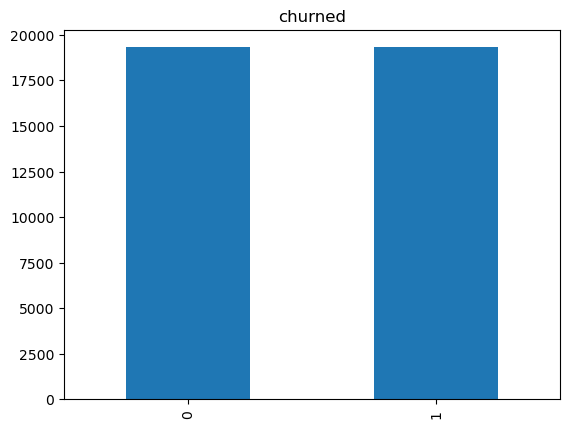

In [200]:
pd.DataFrame(y_train_sm)['churn'].value_counts().plot(kind='bar').set_title('churned')

### Step 4: Performing PCA for feature reduction

In [201]:
X_train_sm.shape

(38618, 162)

In [202]:
#Improting the PCA module
from sklearn.decomposition import PCA
pca = PCA(svd_solver='randomized', random_state=42)

In [203]:
#Performing the PCA on the train data
pca.fit(X_train_sm)

PCA(random_state=42, svd_solver='randomized')

In [204]:
pca.components_

array([[-1.01823869e-01, -9.16704178e-02, -3.44160329e-02, ...,
         1.35864658e-01, -1.10363607e-01,  7.50149056e-02],
       [ 1.41991444e-01,  1.73886954e-01,  1.73495283e-01, ...,
         3.10954364e-02,  1.75037674e-01,  1.04415277e-01],
       [ 7.85942589e-02,  7.58366426e-02,  2.11816075e-03, ...,
         1.29086523e-01,  8.22112413e-02,  1.52955461e-01],
       ...,
       [ 6.81711230e-05,  3.64499264e-05, -5.82165467e-06, ...,
         1.52171863e-03, -5.43543562e-04, -5.47616524e-04],
       [-0.00000000e+00, -1.09137661e-16, -1.08925260e-16, ...,
         3.99396234e-16,  4.24121941e-16, -4.43860553e-17],
       [-0.00000000e+00, -5.94297963e-17, -1.16356171e-16, ...,
        -4.67685071e-16, -1.76316493e-16,  8.10489624e-16]])

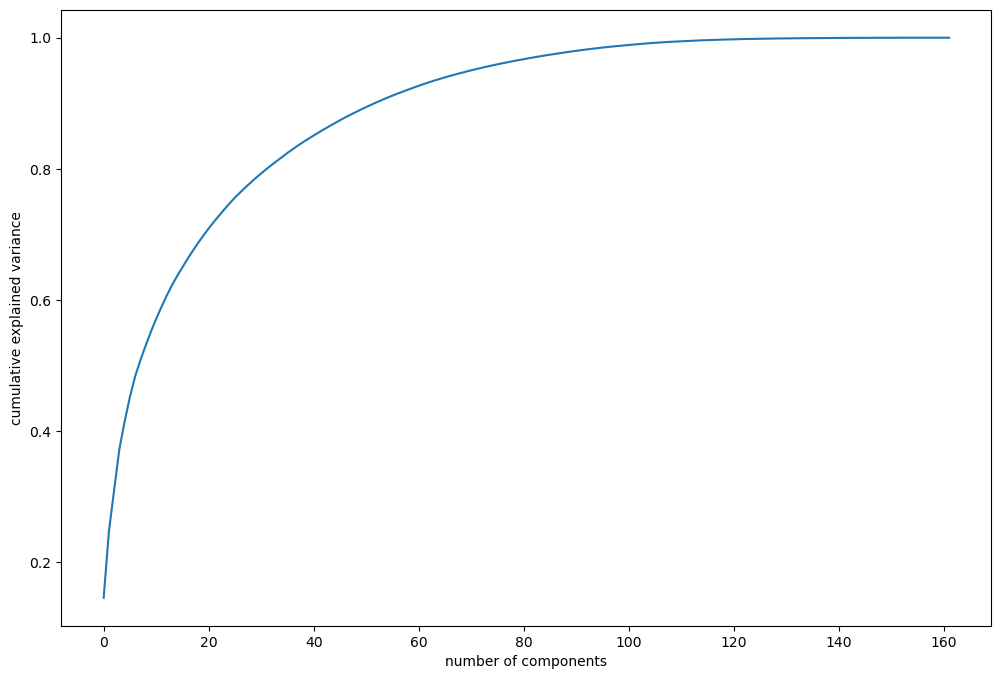

In [205]:
#Making the screeplot - plotting the cumulative variance against the number of components
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

NOTE: > 90% of variance is getting explained by using 55 pc's

In [206]:
#Using incremental PCA for efficiency
from sklearn.decomposition import IncrementalPCA
pca_final = IncrementalPCA(n_components=55)

In [207]:
df_train_pca = pca_final.fit_transform(X_train_sm)
df_train_pca.shape

(38618, 55)

In [208]:
#Applying selected components to the test data - 16 components
df_test_pca = pca_final.transform(X_test)
df_test_pca.shape

(9001, 55)

### Step 5: Model building

#### 1. Logistic Reggression

In [211]:
#Training the model on the train data
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

learner_pca = LogisticRegression(random_state = 42)
model_pca = learner_pca.fit(df_train_pca,y_train_sm)

In [212]:
y_train_pred = model_pca.predict_proba(df_train_pca)[:,1]
y_train_pred

array([0.74869782, 0.03117478, 0.21674083, ..., 0.75642848, 0.69926626,
       0.5848674 ])

In [213]:
y_train_pred_final = pd.DataFrame({'Churn':y_train_sm, 'Churn_Prob':y_train_pred})
y_train_pred_final.head()

,Churn,Churn_Prob
0,0,0.748698
1,0,0.031175
2,0,0.216741
3,0,0.000244
4,0,0.026669


In [214]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]

for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Churn,Churn_Prob,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.748698,1,1,1,1,1,1,1,1,0,0
1,0,0.031175,1,0,0,0,0,0,0,0,0,0
2,0,0.216741,1,1,1,0,0,0,0,0,0,0
3,0,0.000244,1,0,0,0,0,0,0,0,0,0
4,0,0.026669,1,0,0,0,0,0,0,0,0,0


In [215]:
# Calculating accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.500000  1.000000  0.000000
0.1   0.1  0.735693  0.978300  0.493086
0.2   0.2  0.793723  0.958879  0.628567
0.3   0.3  0.825910  0.936040  0.715780
0.4   0.4  0.844373  0.907194  0.781553
0.5   0.5  0.854343  0.873479  0.835206
0.6   0.6  0.851857  0.823502  0.880211
0.7   0.7  0.840308  0.766896  0.913719
0.8   0.8  0.805894  0.666788  0.945000
0.9   0.9  0.673417  0.372106  0.974727


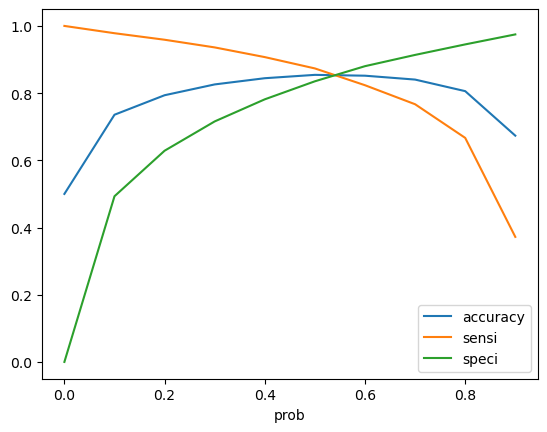

In [216]:
#Plotting accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

From the curve above, 0.54 is the optimum point to take it as a cutoff probability.

In [217]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.54 else 0)
y_train_pred_final.head()

,Churn,Churn_Prob,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.748698,1,1,1,1,1,1,1,1,0,0,1
1,0,0.031175,1,0,0,0,0,0,0,0,0,0,0
2,0,0.216741,1,1,1,0,0,0,0,0,0,0,0
3,0,0.000244,1,0,0,0,0,0,0,0,0,0,0
4,0,0.026669,1,0,0,0,0,0,0,0,0,0,0


In [218]:
confusion = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.final_predicted )
confusion

array([[16483,  2826],
       [ 2786, 16523]])

In [219]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [220]:
#Accuracy
accuracy = (TP+TN)/(TP+TN+FP+FN)
accuracy

0.8546791651561448

In [221]:
#Sensitivity/Recall
recall = TP/(TP+FN)
recall

0.8557149515769849

In [222]:
#Precision
precision = TP/(TP+FP)
precision

0.8539459403586749

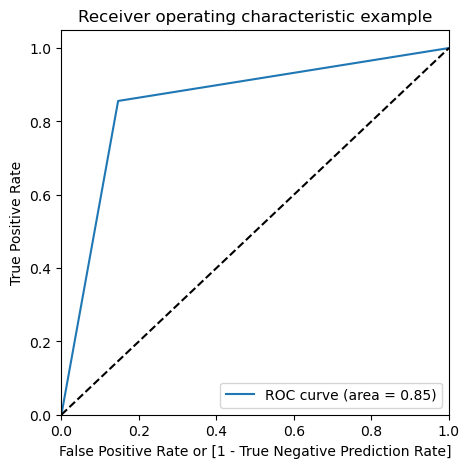

In [223]:
# Defining a function to plot the roc curve
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Prediction Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None
draw_roc(y_train_pred_final.Churn, y_train_pred_final.final_predicted)

In [224]:
#Making prediction on the test data
pred_probs_test = model_pca.predict_proba(df_test_pca)[:,1]
y_test_df=pd.DataFrame(y_test)
y_pred_df=pd.DataFrame(pred_probs_test)
y_test_df.reset_index(drop=True, inplace=True)
y_pred_df.reset_index(drop=True, inplace=True)
y_test_pred_final=pd.concat([y_test_df, y_pred_df],axis=1)

In [226]:
# Renaming the column 
y_test_pred_final= y_test_pred_final.rename(columns={ 0 : 'Churn_prob'})
y_test_pred_final['final_predicted'] = y_test_pred_final.Churn_prob.map(lambda x: 1 if x > 0.54 else 0)

In [227]:
test_confusion = metrics.confusion_matrix(y_test_pred_final.churn, y_test_pred_final.final_predicted )
test_confusion

array([[7114, 1137],
       [ 143,  607]])

In [228]:
TP = test_confusion[1,1] # true positive 
TN = test_confusion[0,0] # true negatives
FP = test_confusion[0,1] # false positives
FN = test_confusion[1,0] # false negatives

In [229]:
#Accuracy
accuracy = (TP+TN)/(TP+TN+FP+FN)
accuracy

0.8577935784912788

In [230]:
#Sensitivity/Recall
recall = TP/(TP+FN)
recall

0.8093333333333333

In [231]:
#Precision
precision = TP/(TP+FP)
precision

0.3480504587155963

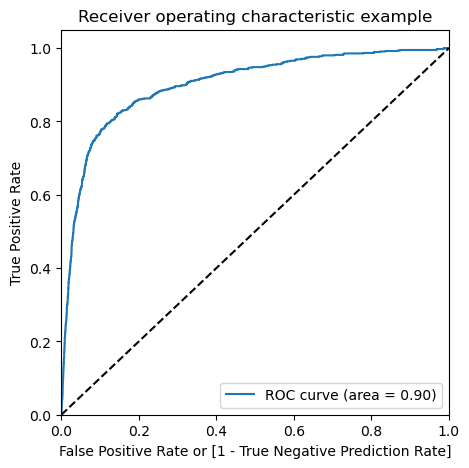

In [232]:
draw_roc(y_test, pred_probs_test)

#### Using Random Forest Model

In [233]:
from sklearn.ensemble import RandomForestClassifier

#running with default parameters
rfc = RandomForestClassifier(random_state = 42)
rfc.fit(df_train_pca,y_train_sm)

RandomForestClassifier(random_state=42)

In [234]:
# Making predictions
predictions = rfc.predict(df_test_pca)

In [235]:
# Importing classification report and confusion matrix from sklearn metrics
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      8251
           1       0.51      0.53      0.52       750

    accuracy                           0.92      9001
   macro avg       0.73      0.74      0.74      9001
weighted avg       0.92      0.92      0.92      9001



##### Tuning hyperparamter

In [81]:
# GridSearchCV to find optimal min_samples_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [4,8,10],
    'min_samples_leaf': range(100, 400, 200),
    'min_samples_split': range(200, 500, 200),
    'n_estimators': [100,200, 300], 
    'max_features': [3, 6]
}
# Create a based model
rf = RandomForestClassifier(random_state=42)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,scoring= 'roc_auc', 
                          cv = 3, n_jobs = -1,verbose = 1)

# Fit the grid search to the data
grid_search.fit(df_train_pca,y_train_sm)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [4, 8, 10], 'max_features': [3, 6],
                         'min_samples_leaf': range(100, 400, 200),
                         'min_samples_split': range(200, 500, 200),
                         'n_estimators': [100, 200, 300]},
             scoring='roc_auc', verbose=1)

In [82]:
# printing the optimal accuracy score and hyperparameters
print('We can get best score of',grid_search.best_score_,'using',grid_search.best_params_)

We can get best score of 0.9326601706117558 using {'max_depth': 10, 'max_features': 6, 'min_samples_leaf': 100, 'min_samples_split': 200, 'n_estimators': 200}


In [244]:
# model with the best hyperparameters
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(bootstrap=True,
                             max_depth=10,
                             min_samples_leaf=100, 
                             min_samples_split=200,
                             max_features=6,
                             n_estimators=200)

In [245]:
# fit
rfc.fit(df_train_pca,y_train_sm)
# predict
predictions = rfc.predict(df_test_pca)

In [246]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.97      0.88      0.92      8251
           1       0.36      0.74      0.48       750

    accuracy                           0.87      9001
   macro avg       0.67      0.81      0.70      9001
weighted avg       0.92      0.87      0.89      9001



In [247]:
# metrics
print(metrics.confusion_matrix(y_test, predictions), "\n")
print("accuracy", metrics.accuracy_score(y_test, predictions))
print("precision", metrics.precision_score(y_test, predictions))
print("sensitivity/recall", metrics.recall_score(y_test, predictions))
print("roc_auc_score", metrics.roc_auc_score(y_test, predictions))

[[7267  984]
 [ 196  554]] 

accuracy 0.8689034551716476
precision 0.3602080624187256
sensitivity/recall 0.7386666666666667
roc_auc_score 0.8097041974710135


NOTE:- Out of Logistic regression and Random Forest, Logistic regression model performance is better which gives recall of 83% and ROC value of .91

##### PART -2 : Model Building for identifying important predictor attributes

In [248]:
y = final_non_outlier_df.churn
X = final_non_outlier_df.drop('churn', axis=1)
# scaling the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled=scaler.fit_transform(X)
X_scaled_df=pd.DataFrame(X_scaled,columns=X.columns)
# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, train_size=0.7, test_size=0.3, random_state=100)

In [249]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
from sklearn.feature_selection import RFE
rfe = RFE(logreg, 60)             # running RFE with 60 variables as output
rfe = rfe.fit(X_train, y_train)

In [250]:
rfe.support_

array([ True,  True, False,  True, False,  True,  True, False,  True,
       False, False, False, False, False,  True, False,  True,  True,
        True,  True, False, False, False, False, False, False, False,
       False,  True, False,  True, False, False, False, False, False,
        True, False, False, False, False, False, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False,  True,  True,  True, False, False, False,  True, False,
        True,  True, False, False,  True, False, False,  True, False,
       False,  True, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
        True, False, False,  True, False,  True, False, False, False,
        True, False, False,  True, False,  True, False, False,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False,

In [251]:
X_scaled_df.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2m_mou_6,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_service_packs_6,total_service_packs_7,total_service_packs_8,diff_ic_og_6,diff_ic_og_7,diff_ic_og_8,diff_vol_3g_2g_6,diff_vol_3g_2g_7,diff_vol_3g_2g_8,diff_total_service_packs_good_active_phase,diff_ic_good_active_phase,diff_og_good_active_phase,diff_2g_good_active_phase,diff_3g_good_active_phase,diff_total_rech_amt_good_active,tenure_range,total_rech_data_amt_good_phase,total_rech_amt_good_phase,total_amt_good_phase
0,-0.981293,-0.932973,-0.742104,-0.624941,-0.618480,-0.575401,-0.842696,-0.832411,-0.793267,-0.275111,-0.249009,-0.250702,-0.286624,-0.265485,-0.264257,-0.508892,-0.508440,-0.509753,-0.741748,-0.754810,-0.722000,-0.410545,-0.414598,-0.407268,-0.340701,-0.349886,-0.337171,-0.754937,-0.769266,-0.738169,-0.486063,-0.239840,-0.236957,-0.233716,-0.607927,-0.609201,-0.552656,-0.15789,-0.469624,-0.501571,-0.491098,-0.378934,0.0,0.0,-0.939654,-0.937762,-0.855283,-0.604023,-0.600660,-0.588904,-0.801975,-0.818891,-0.767423,-0.447248,-0.444166,-0.407161,-0.839849,-0.846756,-0.797635,-0.383406,-0.381056,-0.361611,-0.459906,-0.455463,-0.444915,-0.277911,-0.280672,-0.283002,-0.494711,-0.489180,-0.475347,-0.429418,-0.225046,-0.264334,-0.252757,-0.261666,-0.251352,-0.255320,-0.255868,-0.253294,-0.910296,-0.992863,-0.923280,-0.663028,-0.896781,0.561004,0.534014,0.651698,-1.171518,-2.460396,-3.573362,1.403453,1.384173,1.525398,-0.246124,-0.291457,-0.219195,1.750798,1.721693,1.816500,-0.523747,-0.545530,-0.507977,0.703320,0.646247,0.721728,0.747530,0.653945,0.772258,-0.328994,-0.428845,-0.377315,-0.351964,-0.275915,-0.312722,1.022200,1.004034,1.076554,1.187168,1.129506,1.232167,-0.117272,-0.112507,-0.107224,-0.405519,-0.411758,-0.384384,-0.447405,-0.470068,1.451451,1.395291,1.469397,-0.289488,-0.274042,-0.259548,0.965625,0.953005,1.046932,-0.251881,-0.365591,-0.450988,-0.139295,-0.086347,-0.052833,-0.110143,-0.016121,0.490083,0.488478,0.433282,-0.202232,-0.104066,-0.170139,-0.115538,-0.793941,-0.809626,-0

In [252]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('arpu_6', True, 1),
 ('arpu_7', True, 1),
 ('arpu_8', False, 91),
 ('onnet_mou_6', True, 1),
 ('onnet_mou_7', False, 2),
 ('onnet_mou_8', True, 1),
 ('offnet_mou_6', True, 1),
 ('offnet_mou_7', False, 55),
 ('offnet_mou_8', True, 1),
 ('roam_ic_mou_6', False, 97),
 ('roam_ic_mou_7', False, 86),
 ('roam_ic_mou_8', False, 76),
 ('roam_og_mou_6', False, 72),
 ('roam_og_mou_7', False, 18),
 ('roam_og_mou_8', True, 1),
 ('loc_og_t2t_mou_6', False, 88),
 ('loc_og_t2t_mou_7', True, 1),
 ('loc_og_t2t_mou_8', True, 1),
 ('loc_og_t2m_mou_6', True, 1),
 ('loc_og_t2m_mou_7', True, 1),
 ('loc_og_t2m_mou_8', False, 56),
 ('loc_og_t2f_mou_6', False, 31),
 ('loc_og_t2f_mou_7', False, 11),
 ('loc_og_t2f_mou_8', False, 12),
 ('loc_og_t2c_mou_6', False, 51),
 ('loc_og_t2c_mou_7', False, 101),
 ('loc_og_t2c_mou_8', False, 69),
 ('loc_og_mou_6', False, 87),
 ('loc_og_mou_7', True, 1),
 ('loc_og_mou_8', False, 57),
 ('std_og_t2m_mou_6', True, 1),
 ('std_og_t2f_mou_6', False, 35),
 ('std_og_t2f_mou_7', Fal

In [253]:
col = X_train.columns[rfe.support_]

In [254]:
X_train.columns[~rfe.support_]

Index(['arpu_8', 'onnet_mou_7', 'offnet_mou_7', 'roam_ic_mou_6',
       'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7',
       'loc_og_t2t_mou_6', 'loc_og_t2m_mou_8',
       ...
       'total_service_packs_7', 'total_service_packs_8', 'diff_ic_og_8',
       'diff_vol_3g_2g_6', 'diff_vol_3g_2g_8',
       'diff_total_service_packs_good_active_phase',
       'diff_total_rech_amt_good_active', 'total_rech_data_amt_good_phase',
       'total_rech_amt_good_phase', 'total_amt_good_phase'],
      dtype='object', length=102)

In [255]:
# Importing random forest classifier from sklearn library
from sklearn.ensemble import RandomForestClassifier

# Running the random forest with default parameters.
rfc = RandomForestClassifier()
rfc.fit(X_train[col],y_train)

RandomForestClassifier()

In [256]:
# Making predictions
predictions = rfc.predict(X_test[col])

In [257]:
# Let's check the report of our default model
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      8251
           1       0.77      0.48      0.59       750

    accuracy                           0.94      9001
   macro avg       0.86      0.73      0.78      9001
weighted avg       0.94      0.94      0.94      9001



In [258]:
# GridSearchCV to find optimal min_samples_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [8,12,16],
    'min_samples_leaf': range(100, 800, 200),
    'min_samples_split': range(200, 1000, 200),
    'n_estimators': [100,200, 300], 
    'max_features': [6,9,12]
}
# Create a based model
rf = RandomForestClassifier(random_state=42)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,scoring= 'roc_auc', 
                          cv = 3, n_jobs = -1,verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train[col],y_train)

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [8, 12, 16], 'max_features': [6, 9, 12],
                         'min_samples_leaf': range(100, 800, 200),
                         'min_samples_split': range(200, 1000, 200),
                         'n_estimators': [100, 200, 300]},
             scoring='roc_auc', verbose=1)

In [259]:
# printing the optimal accuracy score and hyperparameters
print('We can get best score of',grid_search.best_score_,'using',grid_search.best_params_)

We can get best score of 0.933069569030326 using {'max_depth': 16, 'max_features': 12, 'min_samples_leaf': 100, 'min_samples_split': 200, 'n_estimators': 200}


In [260]:
# model with the best hyperparameters
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(bootstrap=True,
                             max_depth=16,
                             min_samples_leaf=100, 
                             min_samples_split=200,
                             max_features=12,
                             n_estimators=200)

In [261]:
# fit
rfc.fit(X_train[col],y_train)
# predict
predictions = rfc.predict(X_test[col])

In [262]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      8251
           1       0.76      0.49      0.59       750

    accuracy                           0.94      9001
   macro avg       0.86      0.74      0.78      9001
weighted avg       0.94      0.94      0.94      9001



In [263]:
# metrics
print(metrics.confusion_matrix(y_test, predictions), "\n")
print("accuracy", metrics.accuracy_score(y_test, predictions))
print("precision", metrics.precision_score(y_test, predictions))
print("sensitivity/recall", metrics.recall_score(y_test, predictions))
print("roc_auc_score", metrics.roc_auc_score(y_test, predictions))

[[8135  116]
 [ 384  366]] 

accuracy 0.9444506165981558
precision 0.7593360995850622
sensitivity/recall 0.488
roc_auc_score 0.7369705490243607


#### Advanced Metrics beyond simply accuracy

In [264]:
confusion=metrics.confusion_matrix(y_test, predictions)

In [265]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [266]:
# Let's see the sensitivity of our logistic regression model
Senstivity = TP / float(TP+FN)
Senstivity

0.488

In [267]:
# Let us calculate specificity
specificity = TN / float(TN+FP)
specificity

0.9859410980487213

In [268]:
# Calculate false postive rate - predicting conversion when customer have not converted
FPR=FP/ float(TN+FP)
FPR

0.014058901951278633

In [269]:
# positive predictive value 
PPV = TP / float(TP+FP)
PPV

0.7593360995850622

In [270]:
# Negative predictive value
NPV = TN / float(TN+ FN)
NPV

0.9549242868881324

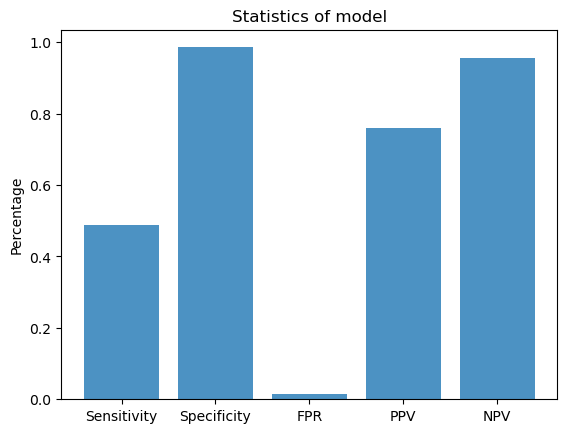

In [271]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = ('Sensitivity', 'Specificity', 'FPR', 'PPV', 'NPV')
y_pos = np.arange(len(objects))
values = [Senstivity,specificity,FPR,PPV,NPV]

plt.bar(y_pos, values, align='center', alpha=0.8)
plt.xticks(y_pos, objects)
plt.ylabel('Percentage')
plt.title('Statistics of model')

plt.show()

#### Finding important features in original data on which our model depends

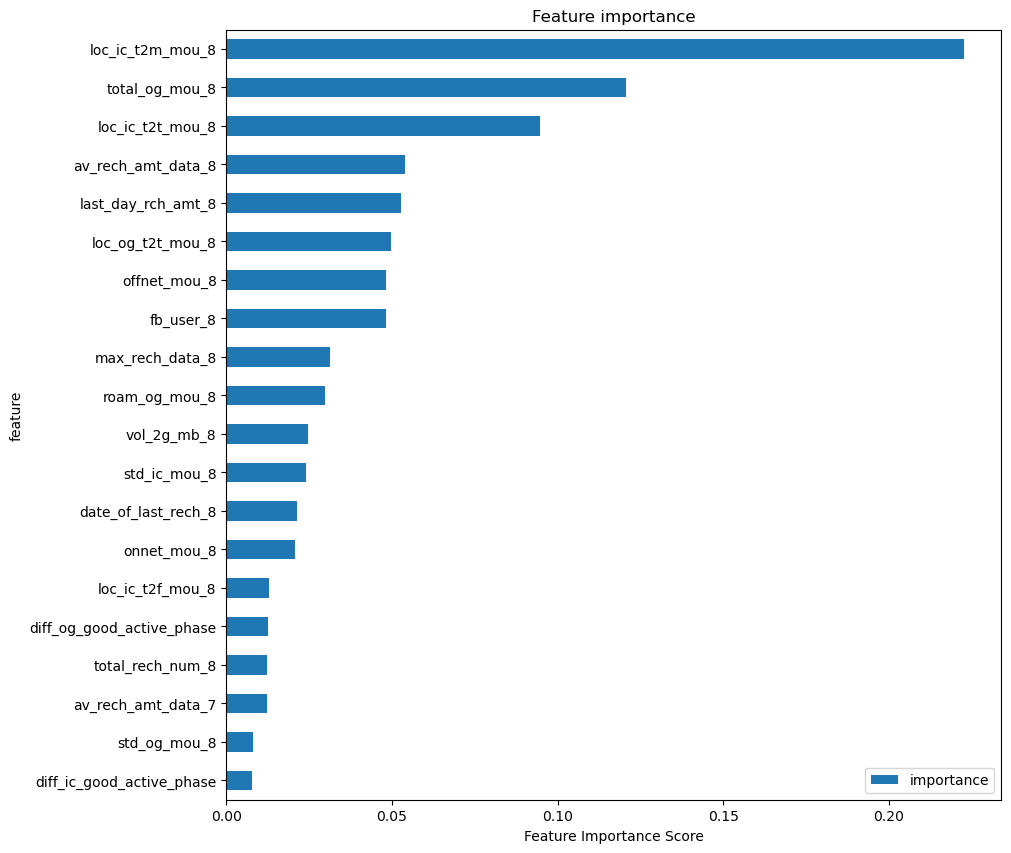

In [272]:
feature_importance_df = pd.DataFrame({'importance':rfc.feature_importances_})
feature_importance_df['feature'] = col
feature_importance_df.sort_values(by='importance', ascending=False, inplace=True)
feature_importance_df = feature_importance_df.iloc[:20]
feature_importance_df.sort_values(by='importance', inplace=True)
feature_importance_df = feature_importance_df.set_index('feature', drop=True)
feature_importance_df.plot.barh(title='Feature importance', figsize=(10,10))
plt.xlabel('Feature Importance Score')
plt.show()

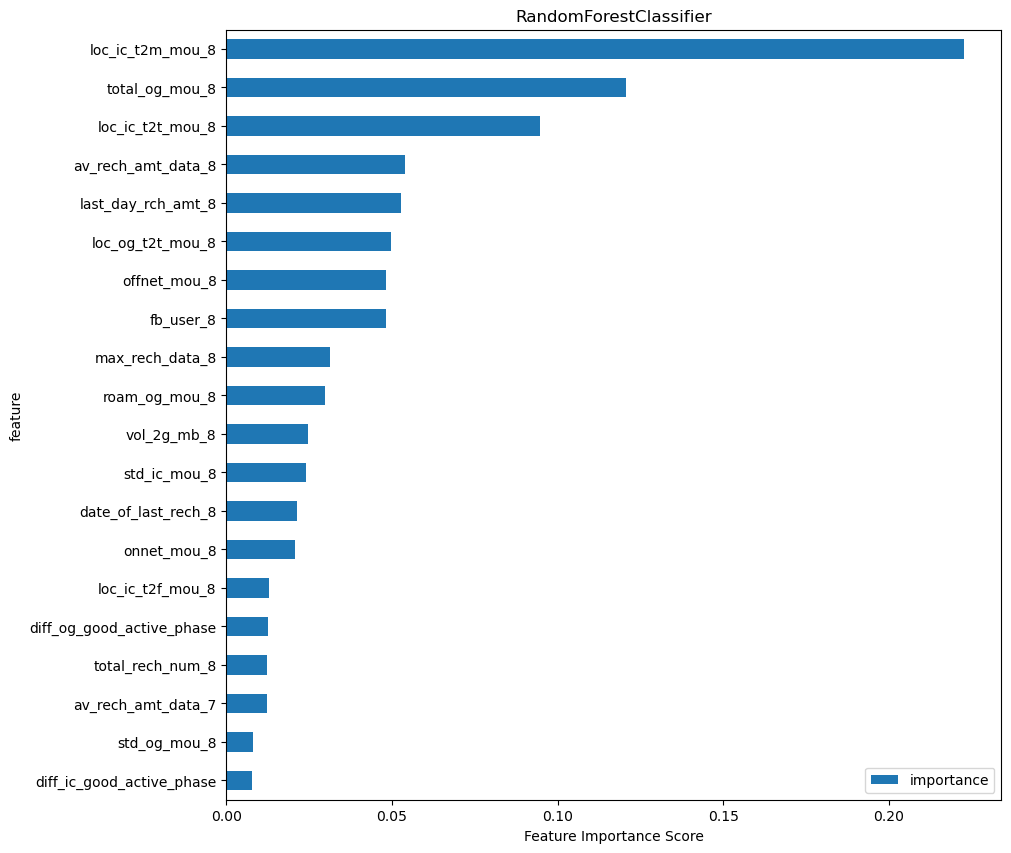

In [273]:
feature_importance_df = pd.DataFrame({'importance':rfc.feature_importances_})
feature_importance_df['feature'] = col
feature_importance_df.sort_values(by='importance', ascending=False, inplace=True)
feature_importance_df = feature_importance_df.iloc[:20]
feature_importance_df.sort_values(by='importance', inplace=True)
feature_importance_df = feature_importance_df.set_index('feature', drop=True)
feature_importance_df.plot.barh(title='RandomForestClassifier', figsize=(10,10))
plt.xlabel('Feature Importance Score')
plt.show()

#### NOTE:
These are the top 20 important features along with their scores

In [274]:
feature_importance_df.sort_values(by='importance', ascending=False)

,importance
feature,
loc_ic_t2m_mou_8,0.222884
total_og_mou_8,0.120670
loc_ic_t2t_mou_8,0.094582
av_rech_amt_data_8,0.054006
last_day_rch_amt_8,0.052625
loc_og_t2t_mou_8,0.049658
offnet_mou_8,0.048320
fb_user_8,0.048280
max_rech_data_8,0.031291
